
solving problem with no guess
initial state [-0.1736486   0.53573545  1.46896263  2.91795523 -1.40528599 -0.62649066]
goal state [ 2.99741224  0.08305251  0.1         0.08305251 -1.33218322  0.        ]
flight time 1.54388718787
num time steps 30
exact traj False
dt 0.0514629062623
SolutionResult.kSolutionFound
expected remaining fuel consumption 173.145995436
took 0.0313169956207 seconds
goal state [ 2.99741224  0.08305251  0.1         0.08305251 -1.33218322  0.        ]
end state [ 2.98197341  0.06761364  0.11543887  0.09849139 -1.31674433 -0.01543887]



<IPython.core.display.Javascript object>


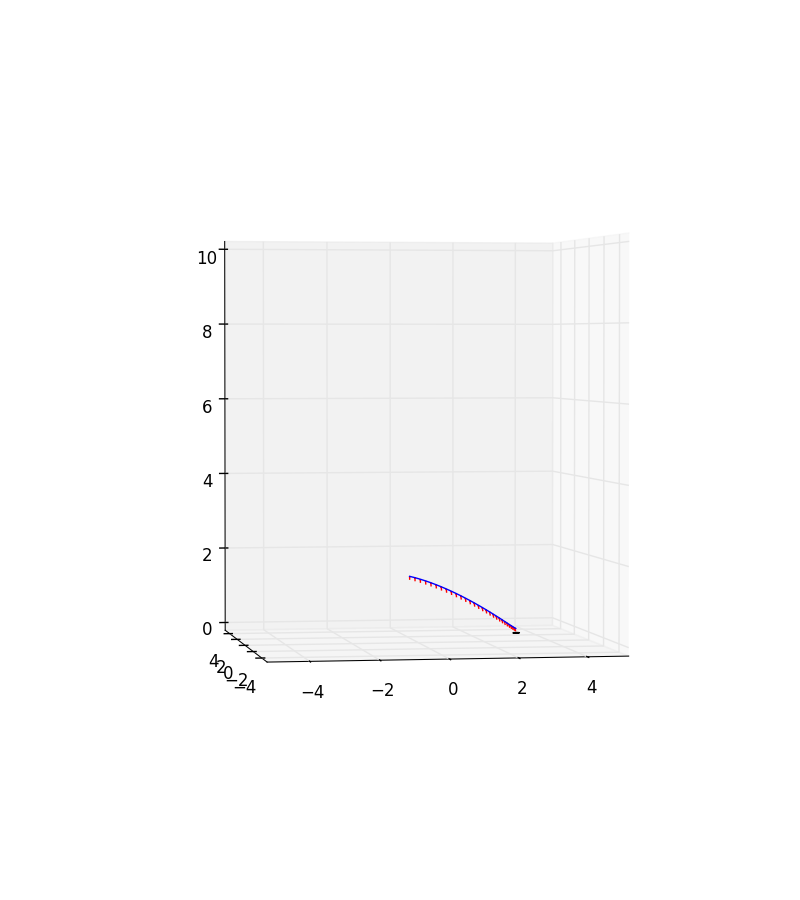

<type 'numpy.ndarray'>
(29,)
took 0.0557289123535 seconds


In [240]:
# credits due to 6.832 Spring 2018 course
# with modifications by Hao Shen
# for 6.832 final project

# Invokes trajectory optimization, given starting state, target end state, and flight_time 
# useful for debugging 

%reload_ext autoreload
%autoreload 2
%matplotlib notebook
import numpy as np
import time

from drone_sim import DroneSim
drone = DroneSim()

# specify starting state
x0 = np.array([-0.1736486,   0.53573545,  1.46896263,  2.91795523, -1.40528599, -0.62649066])
# specify goal state
goal = np.array([ 2.99741224,  0.08305251,  0.1,         0.08305251, -1.33218322,  0.      ])   
# specify flight time
flight_time = 1.543887187869

start_time = time.time()
traj, u_traj, time_array = drone.compute_trajectory(x0, goal, flight_time)
drone.plot_trajectory_with_boosters(traj, u_traj, goal)
print("took %s seconds" % (time.time() - start_time ))


In [272]:
# define tracker
def getGoalState(t):
    # trajectory 1
#     x = t
#     y = 0.0
#     dx = 1.0
#     dy = 0.0
    
    # trajectory 2
    x = 5*np.sin(t/1.5)
    y = 4*np.cos(t/1.5)
    dx = 5./1.5*np.cos(t/1.5)
    dy = -4./1.5*np.sin(t/1.5)
    
    # trajectory 3
#     x = 4*np.sin(t/5.+4)
#     y = 2*np.sin(t)
#     dx = 4./5*np.cos(t/5.+4)
#     dy = 2*np.cos(t)
    state = np.array([x, y, 0.1, \
                      dx, dy, 0.0])
    return state

In [282]:
import numpy as np
import time

from drone_sim import DroneSim
drone = DroneSim()

# calculate earliest point when we hit the target
# traj - current trajectory
# dest - destination state
# time array - time associated with traj
# sim_time current simulation time
def timeToLand(traj, dest, time_array, sim_time):
    assert len(traj) == len(time_array)
    min_dist = None
    
    if time_array[-1] < 1.0: 
        #if the flight time is small, don't worry about finding a shorter time
        dist_vec = traj[-1,:3]-dest[:3]
        vel_vec = traj[-1,-3:]-dest[-3:]
        if dist_vec.dot(dist_vec) < 0.01:
            return time_array[-1], len(traj)-1, dist_vec.dot(dist_vec), True

    for i in range(len(traj)):
#         dest = getGoalState(sim_time + time_array[i]) # maybe this is a better estimate of where the destination is?
        dist_vec = traj[i,:3]-dest[:3]
        vel_vec = traj[i,-3:]-dest[-3:]

        if dist_vec.dot(dist_vec) < 0.01:
            return time_array[i], i, dist_vec.dot(dist_vec), True
        if min_dist is None:
            min_dist = dist_vec.dot(dist_vec) 
            min_i = i
        elif min_dist > dist_vec.dot(dist_vec):
            min_dist = dist_vec.dot(dist_vec)
            min_i = i
            
    return time_array[min_i], min_i, min_dist, False

# add a numpy array to a 1 dimension higher list of arrays
def addElementTo(tracker, element):
    if tracker is None:
        tracker = np.expand_dims(element, axis=0)
    else:
        tracker = np.vstack((tracker, np.expand_dims(element, axis=0)))
    return tracker

# global variables to keep track of
plot_traj = []
plot_booster = None
plot_goal = None
plot_pos = None
plot_vel = None
plot_land_goal = None
total_cost = 0
total_time = 0
    
# high level planner, simulating the drone flying frome start to end with the trajectory calculated at every step
# 
# start - initial state of drone
# end - goal state of landing target
# flight_time - estimated time to land
# time_step - time step to forward simulate system
# prev - length two length with past traj, and forces over time
# exact - whether or not to look for an exact trajector
def SimulateDrone(sim_time, start, end, flight_time, time_step, prev = None, exact = False, verbose = False):
    global plot_traj, plot_booster, plot_goal, plot_land_goal, plot_pos, plot_vel, total_cost, total_time
    
    cur_pos = start[:3]
    cur_vel = start[-3:]
    if verbose:
        print '========================'
        print 'time is', sim_time
        print 'flight time is', flight_time
        print 'position', cur_pos
        print 'velocity', cur_vel
    
    dist_vec = cur_pos-getGoalState(sim_time)[:3]
    vel_vec = cur_vel-getGoalState(sim_time)[-3:]
    
    # if within landing target, we are done
    if dist_vec.dot(dist_vec) < 0.02 and vel_vec.dot(vel_vec) < 0.1 :
        print 'Reached goal! sim time:', sim_time
        return sim_time
    
    # compute landing trajectory
    start_time = time.time()
    traj, u_traj, time_array = drone.compute_trajectory(start, end, flight_time, exact = exact, verbose=verbose)
    total_time += time.time() - start_time
    
    # use previous found path if nan
    if np.isnan(u_traj[0,0]):
        if verbose:
            print 'size of previous traj', len(prev[1])

        if prev is None:
            traj = np.array([start])
            u_traj = np.array([[0, 0, 9.8]])
        else:
            traj = prev[0]
            u_traj = prev[1]
        ttl = flight_time*1.1
        exact_landing = False
        time_index = len(time_array)
        if verbose:
            print '***********GOT NAN***********'
            print 'using past trajectory inputs'
    else:
        # find the estimated time to land 
        ttl, time_index, min_dist, exact_landing = timeToLand(traj, end, time_array, sim_time)

        if verbose:
            print 'goal', end[:3]
        if not exact_landing:
            if verbose:
                if time_index != len(traj)-1:
                    print 'trying to land in', time_array[time_index], 'but not exact'
                else:
                    print 'cannot land in time, extending search horizon'
                    print 'traj end', traj[-1,:3]
            # if our trajectory is nowhere near the target
            if time_index == len(traj)-1 or min_dist > 0.1:
                ttl = flight_time*1.1
        else:
            if verbose:
                print 'closest point', traj[time_index][:3] 
                
    if verbose:
        print 'boosting', u_traj[0,:]
        print time_array
        print 'time to land', ttl
    
    if ttl < 0.5:
        exact_landing = True
        
    # PLOTTING
    plot_goal = addElementTo(plot_goal, getGoalState(sim_time)[:3])
    plot_land_goal = addElementTo(plot_land_goal, end[:3])
    plot_pos = addElementTo(plot_pos, cur_pos)
    plot_vel = addElementTo(plot_vel, cur_vel)
    plot_booster = addElementTo(plot_booster, u_traj[0,:])
    plot_traj.append(traj)
        
#     plot everything
#     drone.plot_trajectory_with_boosters(traj, u_traj, getGoalState(sim_time)[:2])
    
    
    # forward simulate
    next_state = drone.get_next_state(start, u_traj[0,:], time_step)
    total_cost += np.sum(u_traj[0,:]**2)*time_step
    
    # stop simulation if it takes too long
    if sim_time > 8.0:
        return sim_time

    look_ahead_time = min(ttl, 2.0) # can only anticipate 2 second into the future 
    return SimulateDrone(sim_time+time_step, next_state, getGoalState(sim_time+look_ahead_time), ttl, \
              time_step, prev = [traj, u_traj], exact = exact_landing, verbose = verbose)

all_start = []
all_cost = []
all_time = []
all_flight_time = []
for i in range(1):
    #reset everything
    plot_traj = []
    plot_booster = None
    plot_goal = None
    plot_pos = None
    plot_vel = None
    plot_land_goal = None
    total_cost = 0
    total_time = 0
    
    # randomize initial conditions
    randx, randy = np.random.random_sample((2,))*10-5
    randz = np.random.random_sample(1)*5+5
    randdx, randdy, randdz = np.random.random_sample((3,))*5-2.5
    start = np.array([randx, randy, randz, randdx, randdy, randdz])
    
    print start
    end = getGoalState(0.0)
    start_time = time.time()
    sim_time = SimulateDrone(0.0, start, end, 5.0, 0.05, verbose = False)
    print 'total cost', total_cost
    print("took %s seconds" % (total_time))
    
    #put them in
    all_start.append(start)
    all_cost.append(total_cost)
    all_time.append(total_time)
    all_flight_time.append(sim_time)
    
print 'DONE!'

[ 3.10587049  4.69386399  7.15433026 -1.44771275 -0.53031557  2.32362604]
Reached goal! sim time: 3.65
total cost 347.638006161
took 2.21221852303 seconds
DONE!


In [170]:
opt_cost_fixed_time = []

# for all trials, take the total flight time, recalculate the trajectory using that flight time
# this is 'optimal' trajectory taking that flight time
for i in range(len(all_start)):
    start = all_start[i]
    t = all_flight_time[i]

    start_time = time.time()
    traj, u_traj, total_fuel = drone.compute_strict_trajectory(start, getGoalState(t), t, False)
    # check if found a path in the time
    dist_vec = traj[-1,:3]-getGoalState(t)[:3]
    vel_vec = traj[-1,-3:]-getGoalState(t)[-3:]

    # plot
    # drone.plot_trajectory_with_boosters(traj, u_traj, getGoalState(t))

    print 'start at', start
    print 'landing in ', t
    print("took %s seconds" % (time.time() - start_time ))
    print "total fuel", total_fuel

    opt_cost_fixed_time.append(total_fuel)
    
print 'DONE!!'

start at [-1.86131611  0.91483854  6.74442984  2.07362823  0.57176071 -1.12953109]
landing in  2.45
took 0.040708065033 seconds
total fuel 273.344412142
ending errors:
0.00847984774788
0.00543576452508
start at [ 2.06439398 -0.60755293  7.18404547  1.69113401 -1.58793138 -0.29532038]
landing in  2.5
took 0.0397419929504 seconds
total fuel 282.746049597
ending errors:
0.00979327568553
0.0084931668698
start at [-2.01808317 -1.08419094  9.52889447  1.07893487  0.4721049  -2.17072207]
landing in  2.6
took 0.0393130779266 seconds
total fuel 316.491620189
ending errors:
0.00702705240313
0.00802627470617
start at [-4.69500422  3.2318462   6.55858657 -1.22205074  2.21956633  2.4811747 ]
landing in  2.95
took 0.0411398410797 seconds
total fuel 336.540980781
ending errors:
0.00607663533512
0.00887667012576
start at [-1.80919921 -4.49099216  7.69106017  1.07838107  0.47795786 -1.61856946]
landing in  2.55
took 0.0383529663086 seconds
total fuel 303.771958421
ending errors:
0.00702279605553
0.0068

In [207]:
# nonlinear trajectory optimizations using dt as a decision variable
from drone_sim import DroneSim
drone = DroneSim()
import time

# to keep track of everything to compare at the end
opt_cost = []
opt_flight_time = []
for i in range(len(all_start)):
    start_time = time.time()
    start = all_start[i]
    traj, u_traj, time_array, total_fuel = drone.compute_opt_trajectory(start, getGoalState, False)

    dist_vec = traj[-1,:3]-getGoalState(time_array[-1])[:3]
    vel_vec = traj[-1,-3:]-getGoalState(time_array[-1])[-3:]

    if dist_vec.dot(dist_vec) < 0.02 and vel_vec.dot(vel_vec) < 0.02:
        print("took %s seconds" % (time.time() - start_time ))
        opt_cost.append(total_fuel)
        opt_flight_time.append(time_array[-1])
        print total_fuel
        print time_array[-1]
# plot in case we want to
#     drone.plot_trajectory_with_boosters(traj, u_traj, getGoalState(time_array[-1]))

took 0.234031915665 seconds
319.163766735
2.31298230428
took 0.23840713501 seconds
292.459211402
2.0592063129
took 0.221725940704 seconds
330.39993276
2.53556506773
took 0.286036968231 seconds
346.062993599
2.63226603783
took 0.304740905762 seconds
258.943762014
2.08741996073


In [196]:
print all_start
print opt_flight_time
print opt_cost
print all_flight_time
print all_cost


[array([-4.32394818, -0.19741878,  6.31119975, -0.64044535,  0.40688603,
       -1.88790573])]
[1.9530075949243664, 2.1074251469604173, 2.1518857637060886, 2.677419487599312, 2.1303027118162881, 2.4390969676520697, 2.1601307272467896, 2.5219669443871857, 2.0824071268771629, 2.4258453913201596, 2.3976180658981789, 2.1094261066240487, 2.1425545547103253, 2.2312184993585502, 2.6464293756225614, 2.1577524557432493, 1.9504144565228736, 2.3568657125764374, 2.0491288372164558, 2.2756216134926461, 1.9724196057247996, 2.443684299597936, 2.1584589310964302, 2.2906699541517774, 2.201434914259659, 2.2519042701171861, 2.1107327575924524, 2.0589746440101675, 1.957488937763358, 2.7242683511594836]
[257.18858443827804, 278.27644980892234, 305.79052944862246, 346.02399348293619, 294.81217359639976, 315.79090936959795, 295.08512516952658, 328.63236960563387, 271.32502373444828, 326.29650716824705, 314.69293285958491, 312.96060027207079, 267.36906581018826, 314.11474204637074, 360.03635519875911, 284.898

In [266]:
# post process velocity and force vectors for plotting

row_norms = np.linalg.norm(plot_vel, axis=1)
normalized_plot_vel =  plot_vel / row_norms[:, np.newaxis]

scaled_plot_vel = plot_vel/5.
scaled_plot_booster = plot_booster/5.

# post process the past values
past_pos = []
for i in range(1, len(plot_pos)+1):    
    past_pos.append(plot_pos[:i,:])


<IPython.core.display.Javascript object>


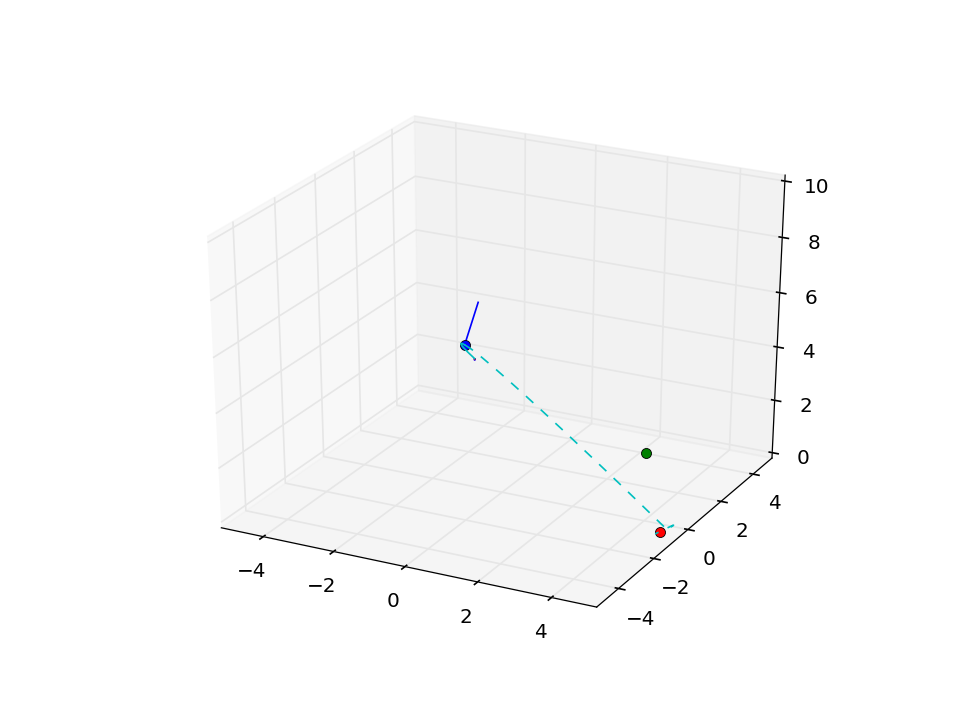

In [267]:
%reload_ext autoreload
%autoreload 2
%matplotlib notebook
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import animation

# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure(figsize=(8,6), dpi=120)
ax = fig.gca(projection='3d')
ax.set_xlim([-5,5])
ax.set_ylim([-5,5])
ax.set_zlim([0,10])
drone_plot, = ax.plot([], [], [], 'o')
goal, = ax.plot([], [], [], 'o')
land_goal, = ax.plot([],[],[],'o')
past_drone, = ax.plot([], [], [])
future_drone, = ax.plot([], [], [], 'c--')
past_x = []
past_y = []
past_z = []

# for quivers
def compute_segs(i):
    x = np.array([[[plot_pos[i,0],plot_pos[i,0]]]])
    y = np.array([[[plot_pos[i,1],plot_pos[i,1]]]])
    z2 = np.array([[[plot_pos[i,2],plot_pos[i,2]]]])
    u = np.array([[[plot_pos[i,0]+scaled_plot_vel[i,0],plot_pos[i,0]+scaled_plot_booster[i,0]]]])
    v = np.array([[[plot_pos[i,1]+scaled_plot_vel[i,1],plot_pos[i,1]+scaled_plot_booster[i,1]]]])
    w = np.array([[[plot_pos[i,2]+scaled_plot_vel[i,2],plot_pos[i,2]+scaled_plot_booster[i,2]]]])
    return x,y,z2,u,v,w

segs = compute_segs(0)
quivers = ax.quiver(*segs, length=0.1, colors = ['r','b'])

# initialization function: plot the background of each frame
def init():
    drone_plot.set_data([], [])
    drone_plot.set_3d_properties([])
    goal.set_data([], [])
    goal.set_3d_properties([])
    land_goal.set_data([], [])
    land_goal.set_3d_properties([])
    
    past_x = []
    past_y = []
    past_z = []
    past_drone.set_data([], [])
    past_drone.set_3d_properties([])
    
    future_drone.set_data([], [])
    future_drone.set_3d_properties([])
    
    segs = compute_segs(0)
    quivers = ax.quiver(*segs, length=0.1, colors = ['r','b'])
    return drone_plot, goal, land_goal, past_drone, future_drone, quivers

# animation function.  This is called sequentially
def animate(i):
    drone_x, drone_y, drone_z = plot_pos[i,:]
    goal_x, goal_y, goal_z = plot_goal[i,:]
    drone_plot.set_data(drone_x, drone_y)
    drone_plot.set_3d_properties(drone_z)
    goal.set_data(goal_x, goal_y)
    goal.set_3d_properties(goal_z)
    land_goal_x, land_goal_y, land_goal_z = plot_land_goal[i,:3]
    land_goal.set_data(land_goal_x, land_goal_y)
    land_goal.set_3d_properties(land_goal_z) 
    
    past_drone.set_data(past_pos[i][:,0], past_pos[i][:,1])
    past_drone.set_3d_properties(past_pos[i][:,2])
    future_drone.set_data(plot_traj[i][:,0], plot_traj[i][:,1])
    future_drone.set_3d_properties(plot_traj[i][:,2])
    
    segs = np.array(compute_segs(i)).reshape(6,-1)
    new_segs = [[[x,y,z],[u,v,w]] for x,y,z,u,v,w in zip(*segs.tolist())]
    quivers.set_segments(new_segs)
    return drone_plot, goal, land_goal, past_drone, quivers

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=len(plot_pos), interval=100, blit=True, repeat=True)
plt.show()
# Writer = animation.writers['ffmpeg']
# writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)
# anim.save('path1.mp4', writer=writer)

<IPython.core.display.Javascript object>


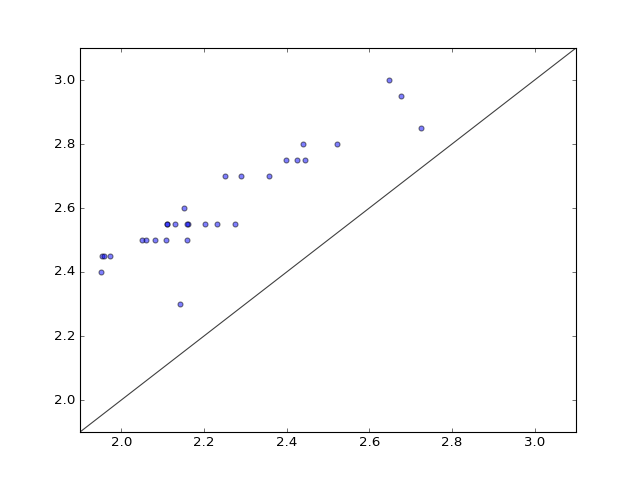

In [287]:
%reload_ext autoreload
%autoreload 2
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
# 1
x=[1.9530075949243664, 2.1074251469604173, 2.1518857637060886, 2.677419487599312, 2.1303027118162881, 2.4390969676520697, 2.1601307272467896, 2.5219669443871857, 2.0824071268771629, 2.4258453913201596, 2.3976180658981789, 2.1094261066240487, 2.1425545547103253, 2.2312184993585502, 2.6464293756225614, 2.1577524557432493, 1.9504144565228736, 2.3568657125764374, 2.0491288372164558, 2.2756216134926461, 1.9724196057247996, 2.443684299597936, 2.1584589310964302, 2.2906699541517774, 2.201434914259659, 2.2519042701171861, 2.1107327575924524, 2.0589746440101675, 1.957488937763358, 2.7242683511594836]
# x =[257.18858443827804, 278.27644980892234, 305.79052944862246, 346.02399348293619, 294.81217359639976, 315.79090936959795, 295.08512516952658, 328.63236960563387, 271.32502373444828, 326.29650716824705, 314.69293285958491, 312.96060027207079, 267.36906581018826, 314.11474204637074, 360.03635519875911, 284.89891865839945, 263.08358436979483, 303.69031022866233, 275.26048723642577, 290.0103024961237, 259.64806326112307, 314.91930977517802, 288.17551298803477, 285.51521939340563, 264.93017614733856, 307.6963045280404, 284.62775629122461, 292.75338261827687, 270.88911949858345, 319.7154515038464]
y=[2.4499999999999993, 2.499999999999999, 2.5999999999999988, 2.9499999999999975, 2.549999999999999, 2.799999999999998, 2.549999999999999, 2.799999999999998, 2.499999999999999, 2.7499999999999982, 2.7499999999999982, 2.549999999999999, 2.3, 2.549999999999999, 2.9999999999999973, 2.499999999999999, 2.3999999999999995, 2.6999999999999984, 2.499999999999999, 2.549999999999999, 2.4499999999999993, 2.7499999999999982, 2.549999999999999, 2.6999999999999984, 2.549999999999999, 2.6999999999999984, 2.549999999999999, 2.499999999999999, 2.4499999999999993, 2.849999999999998]
# y=[280.2486689270097, 293.62191085846047, 316.32680069430927, 334.31627005130514, 313.17204748605064, 317.8690462816607, 308.53237699527386, 330.32904193435644, 285.25515805464744, 322.46827030796317, 317.6436967581617, 334.61363855152911, 278.13104358195045, 321.17804034122366, 356.57435224272479, 296.61880074784608, 280.29396163135135, 308.26842163708733, 294.119623284505, 303.09743539335079, 276.87978520203751, 319.78936760449636, 297.31947911057097, 294.08546489879893, 271.62857593350651, 313.03706594743136, 300.54120534930064, 314.21128899333735, 299.52672682776517, 311.72526972588605]

# 2
# x=[2.7007072822032576, 2.291796352505675, 2.2315453408978665, 2.3381497581103137, 2.2982354596151509, 2.4600181738201554, 2.9364297705342191, 2.4835968333515215, 2.6695532633683938, 2.6045189659608141, 2.032983844747275, 2.5780842986807193, 2.4905841250553471, 2.0383120341466632, 3.6405592395976334, 1.9567362994796162, 3.5437019507777068, 2.7260354734940657, 3.2932697339315693, 2.3303671163249731, 2.4226114183500123, 2.6621743327368046, 2.186956260862595, 2.6585026740560416, 2.1312665378857134, 2.7284604034162427, 2.33735780006459, 2.1150473712470186, 2.6865504263479409, 2.1326677689247266]
# x =[362.21020637643522, 298.17635560304802, 265.20020851221864, 317.00037753299966, 324.1658899688008, 306.22458772063101, 417.73705919140252, 307.28191204246599, 340.76624042705379, 382.91351382100459, 279.64202285616983, 336.21194662965803, 321.11359374246223, 261.03502887303745, 451.71935694943016, 251.84049642880072, 450.68923646490123, 400.76641637758343, 437.93516048234619, 293.10280303932859, 307.02979795032741, 372.01406131145495, 319.55748052096811, 346.2217560536057, 277.73981428997911, 377.78723035819411, 289.61046768248411, 257.28649227340361, 330.86741971277127, 288.14196645918611]
# y=[3.699999999999995, 3.649999999999995, 3.599999999999995, 3.649999999999995, 3.649999999999995, 3.649999999999995, 3.699999999999995, 3.649999999999995, 3.699999999999995, 3.649999999999995, 3.5499999999999954, 3.699999999999995, 3.699999999999995, 3.5499999999999954, 3.699999999999995, 3.5499999999999954, 3.699999999999995, 3.699999999999995, 3.699999999999995, 3.649999999999995, 3.649999999999995, 3.699999999999995, 3.599999999999995, 3.699999999999995, 3.5499999999999954, 3.699999999999995, 3.649999999999995, 3.649999999999995, 3.649999999999995, 3.599999999999995]
# y= [384.84440730382812, 356.50367449193197, 343.29064919432074, 376.64678706840056, 402.05019684465094, 349.51125736167751, 435.1248019300449, 355.77325472306217, 366.26538452946062, 432.94820965164075, 387.22031745157301, 373.35695142846214, 360.97901974277693, 357.23836866606223, 438.43185245606531, 360.6006410661397, 446.74828978553541, 440.84661601896534, 453.43691069570707, 347.6864836437357, 350.36806171230739, 395.73165916715749, 398.05253477907178, 370.06348780357513, 358.13844765470333, 418.56052817300326, 345.60204707879029, 342.644176138837, 381.16681460786123, 373.1054336311596]

# 3
# x= [2.2008509021061373, 2.4694325801419255, 2.8653046911651527, 2.8133125447590617, 2.2569573926992308, 2.4757542613278831, 2.1615783399547728, 2.1240129779067751, 1.7171977884066725, 2.2133758743931993, 2.2921175430827061, 2.264402038317864, 2.6936748831730917, 1.8348608470132464, 2.3165757289146076, 2.7532788281420415, 2.6893245848635416, 2.4616855376643416, 2.2415397683635798, 2.2344339795445034, 2.6493352554639271, 2.0536991209014981, 2.471554481281105, 2.4314335653590948, 2.2911174060391906, 1.9790098584560423, 2.7927662660640276, 2.5622004986709488, 2.4882807811291183, 2.377199805599663]
# x = [294.30404001285081, 322.800429400415, 376.82732355977026, 385.70321721080052, 323.95080875165633, 326.93833507772871, 283.2807448640695, 293.87372469017123, 226.70546245364844, 296.29412011605814, 284.13626505069442, 332.82946621987475, 357.57093823724102, 236.68841048829952, 291.80286977333918, 361.88986989805119, 342.38073796239837, 313.05910260410405, 300.58975483383307, 267.98929307724734, 358.89091886899843, 248.70410398800135, 347.66869003632667, 319.84664362346535, 313.297859202388, 265.31159812470833, 368.8850652931809, 331.15692267026787, 328.85454117497659, 289.36314547898309]
# y=[2.5999999999999988, 2.799999999999998, 2.9499999999999975, 2.849999999999998, 2.5999999999999988, 2.5999999999999988, 2.499999999999999, 2.5999999999999988, 2.25, 2.499999999999999, 2.6499999999999986, 2.6499999999999986, 2.8999999999999977, 2.3999999999999995, 2.6499999999999986, 2.849999999999998, 2.7499999999999982, 2.5999999999999988, 2.5999999999999988, 2.5999999999999988, 2.849999999999998, 2.6499999999999986, 2.5999999999999988, 2.849999999999998, 2.5999999999999988, 2.3999999999999995, 2.9999999999999973, 2.7499999999999982, 2.6999999999999984, 2.5999999999999988]
# y = [313.64366168237956, 323.0813799767086, 388.85814611525831, 384.52876000242435, 341.18821879703239, 328.05448093326436, 298.2523150999524, 306.77239661539107, 256.38962042074519, 309.46290119490425, 295.65043941311637, 348.49009797698102, 357.05057349020649, 272.94302719706513, 293.02765066038523, 371.15480354927462, 341.86818784938185, 316.7114287774375, 310.58335718056236, 275.97900896039954, 353.23401169889809, 268.57207628424561, 358.07446395627932, 317.53478966977889, 328.46912331230203, 297.24658503253102, 371.07168815416014, 336.27402914767362, 327.55958183438435, 291.77937873899043]
# now plot both limits against eachother
fig, ax = plt.subplots()
ax.scatter(x, y, alpha=0.5)

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_xlim(lims)
ax.set_ylim(lims)
plt.show()
plt.savefig('time1.png')